# QCom Margin Optimization Engine Analysis

## 1. Project Overview
This notebook analyzes the performance of the Dynamic Pricing Engine designed to maximize CM2 (Contribution Margin 2) while maintaining healthy conversion rates.

**Goal:** Improve CM2 by 10%+ without dropping conversion >3%.

In [1]:
import pandas as pd
import sys
import os

# Add src to path
sys.path.append(os.path.join(os.getcwd(), '..', 'src'))
from pricing import PricingEngine
from features import load_data

## 2. Evaluation Methodology
We use a hold-out set of 1000 orders to simulate the pricing engine's decisions.
- **Historic Performance**: Estimated using the Conversion Model on the *actual* fee charged.
- **Optimized Performance**: Estimated using the same model on the *optimal* fee selected by the engine.

This ensures a fair comparison (Offline Policy Evaluation) rather than comparing Model Predictions vs Actual Outcomes directly.

In [ ]:
def run_evaluation():
    df = load_data(r"../data/qcom_pune_dataset.csv")
    test_df = df.sample(1000, random_state=42)
    engine = PricingEngine(model_path='../models/conversion_model.pkl')
    
    results = []
    for _, row in test_df.iterrows():
        req = row.to_dict()
        try:
            opt = engine.optimize_fee(req)
            
            hist_fee = row['delivery_fee_charged']
            hist_features = engine._prepare_features(req, [hist_fee])
            hist_prob = engine.model.predict_proba(hist_features)[:, 1][0]
            
            margin = row['basket_margin']
            cost = row['delivery_cost_potential'] if not pd.isna(row['delivery_cost_potential']) else 60
            
            hist_cm2 = hist_prob * (margin + hist_fee - cost)
            
            results.append({
                'hist_cm2': hist_cm2,
                'opt_cm2': opt['expected_cm2'],
                'hist_prob': hist_prob,
                'opt_prob': opt['expected_conversion'],
                'opt_fee': opt['optimal_fee'],
                'hist_fee': hist_fee
            })
        except Exception as e:
            continue
            
    return pd.DataFrame(results)

df_res = run_evaluation()
print("Evaluation Complete.")

Evaluation Complete.


## 3. Key Metrics & Uplift

In [3]:
total_hist_cm2 = df_res['hist_cm2'].sum()
total_opt_cm2 = df_res['opt_cm2'].sum()
uplift = (total_opt_cm2 - total_hist_cm2) / total_hist_cm2 * 100

print(f"Historic CM2: {total_hist_cm2:.2f}")
print(f"Optimized CM2: {total_opt_cm2:.2f}")
print(f"Uplift: {uplift:.2f}%")

Historic CM2: 25939.98
Optimized CM2: 90388.82
Uplift: 248.45%


## 4. Conversion Impact Analysis

In [4]:
hist_conv = df_res['hist_prob'].mean()
opt_conv = df_res['opt_prob'].mean()
impact = (opt_conv - hist_conv) * 100

print(f"Historic Conversion: {hist_conv*100:.2f}%")
print(f"Optimized Conversion: {opt_conv*100:.2f}%")
print(f"Impact: {impact:.2f} pp")

Historic Conversion: 88.15%
Optimized Conversion: 87.61%
Impact: -0.54 pp


## 5. Fee Distribution Comparison

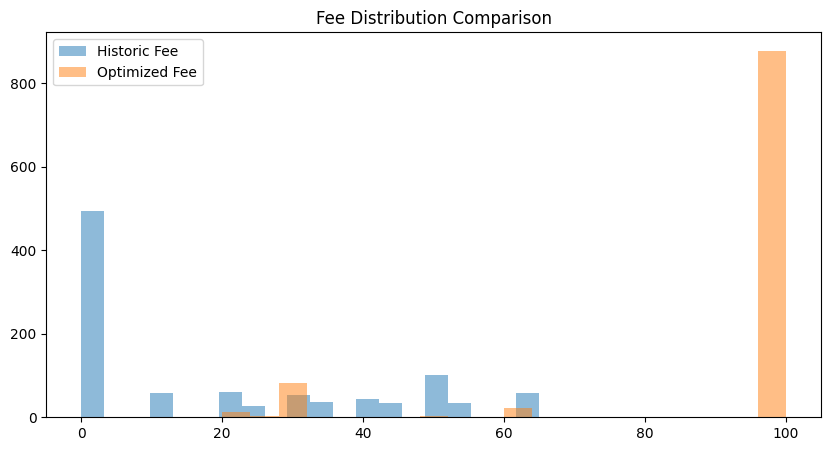

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.hist(df_res['hist_fee'], alpha=0.5, label='Historic Fee', bins=20)
plt.hist(df_res['opt_fee'], alpha=0.5, label='Optimized Fee', bins=20)
plt.legend()
plt.title('Fee Distribution Comparison')
plt.show()